<div class="alert alert-block alert-info" align=center><h1>Accounting Fraud Detection Data Wrangling</h1></div>

<div class="alert alert-block alert-info"><b>We are going to look at a dataset from a 2020 FraudDetection GitHub repository. </b></div>

## <div class="alert alert-block alert-info" ><h1>Imports</h1></div>

In [1]:
#!pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer



#Start a timer to check the execution time of the notebook.
start_time = time.time()

## <div class="alert alert-block alert-info" ><h1>Function Definitions</h1></div>

In [3]:
def plot_fraud_scatter(data, x_feat, y_feat, 
                       hue_col='misstate',
                       palette={0: 'red', 1: 'blue'}):  #palette={0: '#66c2a5', 1: '#fc8d62'})
    """
    Plots a colorblind-safe scatterplot of two features with fraud highlighting.

    Parameters:
    - data: pandas DataFrame
    - x_feat: str, feature name for x-axis
    - y_feat: str, feature name for y-axis
    - hue_col: str, column to color by (default='misstate')
    - palette: dict, color mapping for hue values
    """
    plt.figure(figsize=(8, 6))
    # Plot non-fraud (assumed 0)
    sns.scatterplot(
        data=data[data[hue_col] == 0],
        x=x_feat,
        y=y_feat,
        label='Non-Fraud',
        color=palette[0],
        alpha=0.2,
        s=10
    )

    # Plot fraud (assumed 1)
    sns.scatterplot(
        data=data[data[hue_col] == 1],
        x=x_feat,
        y=y_feat,
        label='Fraud',
        color=palette[1],
        alpha=0.8,
        s=30
    )
    plt.title(f'Fraud vs Non-Fraud: {x_feat} vs {y_feat}')
    plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [4]:
def plot_fraud_pairplot(data, features, hue_col='misstate', palette={0: '#66c2a5', 1: '#fc8d62'}):
    """
    Plots a Seaborn pairplot for selected features, highlighting fraud cases.

    Parameters:
    - data: pandas DataFrame
    - features: list of str, feature names to plot
    - hue_col: column to color by (default='misstate')
    - palette: dict, color mapping for hue values
    """
    sns.pairplot(
        data=data[features + [hue_col]],
        hue=hue_col,
        palette=palette,
        plot_kws={'alpha': 0.4, 's': 20},
        diag_kws={'fill': True},
        corner=True
    )
    plt.suptitle('Fraud Pairwise Feature Patterns', y=1.02)
    plt.show()



In [5]:
def custom_fraud_pairplot(data, features, hue_col='misstate',
                          palette={0: '#66c2a5', 1: '#fc8d62'},
                          alpha_map={0: 0.2, 1: 0.8},
                          size_map={0: 10, 1: 30}):
    """
    Custom pairplot using matplotlib to support different alpha and size per class.

    Parameters:
    - data: pandas DataFrame
    - features: list of 2 or 3 feature names
    - hue_col: column with class label (default: 'misstate')
    - palette: dict mapping class to color
    - alpha_map: dict mapping class to alpha
    - size_map: dict mapping class to marker size
    """
    n = len(features)
    fig, axes = plt.subplots(n, n, figsize=(4 * n, 4 * n))

    for i, xi in enumerate(features):
        for j, yj in enumerate(features):
            ax = axes[i, j]

            if i < j:
                ax.axis("off")            
                continue
            elif i == j:
                for cls in data[hue_col].unique():
                    subset = data[data[hue_col] == cls]
                    sns.kdeplot(
                        subset[features[i]],
                        ax=ax,
                        label=f'{hue_col}={cls}' if i == 0 else "",
                        color=palette[cls],
                        alpha=alpha_map[cls],
                        linewidth=2,
                        fill=True
                    )
            
                ax.set_ylabel("Density")
                ax.set_xlabel(features[i])
            #continue
            else:

                for cls in data[hue_col].unique():
                    subset = data[data[hue_col] == cls]
                    ax.scatter(
                        subset[yj], subset[xi],
                        label=f'{hue_col}={cls}' if (i == n - 1 and j == 0) else "",
                        alpha=alpha_map[cls],
                        c=palette[cls],
                        s=size_map[cls]
                    )

                if i == n - 1:
                    ax.set_xlabel(yj)
                else:
                    ax.set_xlabel("")

                if j == 0:
                    ax.set_ylabel(xi)
                else:
                    ax.set_ylabel("")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title=hue_col, bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.suptitle("Fraud vs Non-Fraud — Custom Pairplot", y=1.02)
    plt.tight_layout()
    plt.show()


## <div class="alert alert-info"><h1>Load the Data</h1></div>

In [6]:
datapath = "../data/raw//data_FraudDetection_JAR2020.csv"
fraud_data = pd.read_csv(datapath)

<div class="alert alert-block alert-info"><b>We are going to look into the details of our data.</b><br><br>
This includes info, describe(), shape, checking for nulls, and more</div>

In [7]:
fraud_data.info

<bound method DataFrame.info of         fyear   gvkey  p_aaer  misstate       act       ap        at  \
0        1990    1009     NaN         0    10.047    3.736    32.335   
1        1990    1011     NaN         0     1.247    0.803     7.784   
2        1990    1017     NaN         0    55.040    3.601   118.120   
3        1990    1021     NaN         0    24.684    3.948    34.591   
4        1990    1028     NaN         0    17.325    3.520    27.542   
...       ...     ...     ...       ...       ...      ...       ...   
146040   2014  314866     NaN         0   262.600   12.400  1234.800   
146041   2014  315318     NaN         0  1578.400  106.700  4557.600   
146042   2014  316056     NaN         0   973.800  249.500  2015.900   
146043   2014  317260     NaN         0    51.743    1.555   322.421   
146044   2014  317264     NaN         0   233.211    5.224  1099.101   

             ceq      che      cogs  ...  soft_assets     ch_cs     ch_cm  \
0          6.262    0.002 

In [8]:
#To start building a code book, let's examine column names
fraud_data.columns

Index(['fyear', 'gvkey', 'p_aaer', 'misstate', 'act', 'ap', 'at', 'ceq', 'che',
       'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib', 'invt', 'ivao',
       'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale',
       'sstk', 'txp', 'txt', 'xint', 'prcc_f', 'dch_wc', 'ch_rsst', 'dch_rec',
       'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm',
       'dpi', 'reoa', 'EBIT', 'ch_fcf'],
      dtype='object')

In [9]:
fraud_data.columns = fraud_data.columns.str.lower()

In [10]:
fraud_data.describe()

,fyear,gvkey,p_aaer,misstate,act,ap,at,ceq,che,cogs,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,ebit,ch_fcf
count,146045.000000,146045.000000,964.000000,146045.000000,146045.000000,146045.000000,146045.000000,146045.000000,146045.000000,146045.000000,...,145453.000000,130127.000000,128938.000000,133367.000000,146045.000000,146027.000000,136817.000000,145454.000000,145454.000000,140638.000000
mean,2002.011702,54243.435516,2503.840249,0.006601,737.847759,181.993488,2374.041576,887.126243,218.657186,1302.280756,...,0.499790,0.185169,-0.090980,-0.010208,0.863487,0.466137,1.042207,-3.191197,-0.238754,-0.008842
std,6.959894,59937.455765,912.093250,0.080976,3744.542368,1047.546104,11957.736980,5056.948150,1330.490185,7870.665783,...,0.274129,1.383354,2.844807,0.379574,0.343333,1.314661,0.495286,12.932219,1.059134,0.548216
min,1990.000000,1004.000000,371.000000,0.000000,-0.254000,0.000000,0.000000,-25560.000000,-34.000000,-366.645000,...,0.004515,-6.484197,-17.359699,-1.671565,0.000000,-7.034304,0.151757,-89.013245,-7.016393,-2.980601
25%,1996.000000,10658.000000,1803.000000,0.000000,8.277000,1.151000,18.281000,6.337000,1.144000,6.795000,...,0.270023,-0.073635,-0.260164,-0.058635,1.000000,0.191546,0.854248,-0.894633,-0.128135,-0.123402
50%,2002.000000,25088.000000,2620.500000,0.000000,47.501000,6.462000,105.346000,47.308000,9.373000,53.382000,...,0.524640,0.067918,-0.023205,-0.001893,1.000000,0.442172,0.974302,-0.008046,0.043701,-0.026155
75%,2008.000000,66586.000000,3180.000000,0.000000,249.832000,42.259000,672.929000,271.547000,60.286000,372.730000,...,0.726663,0.250237,0.139960,0.042188,1.000000,0.805320,1.097582,0.229724,0.108059,0.062294
max,2014.000000,317264.000000,3996.000000,1.000000,152629.000000,39903.000000,410074.000000,284434.000000,85709.000000,435726.253000,...,0.993599,9.600000,16.573810,1.621628,1.000000,4.937457,4.036458,0.784573,0.550619,4.061810


In [11]:
fraud_data.shape

(146045, 46)

In [12]:
# Find columns with nulls
fraud_data.isnull().sum()[fraud_data.isnull().sum() > 0]

p_aaer         145081
dch_wc           4759
ch_rsst          4851
dch_rec          4743
dch_inv          4615
soft_assets       592
ch_cs           15918
ch_cm           17107
ch_roa          12678
bm                 18
dpi              9228
reoa              591
ebit              591
ch_fcf           5407
dtype: int64

In [13]:
fraud_data['p_aaer'].sort_values().head()

8650    371.0
2486    389.0
1945    395.0
8350    473.0
3950    473.0
Name: p_aaer, dtype: float64

<div class="alert alert-block alert-info">p_aaer is a flag for SEC accounting and auditing enforcement releases<br>
The non-nulls represent AAER document IDs, not scores.<br>
We will drop this column</div>


In [14]:
fraud_data.drop(columns=['p_aaer'],inplace=True)

In [15]:
fraud_data.head()

,fyear,gvkey,misstate,act,ap,at,ceq,che,cogs,csho,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,ebit,ch_fcf
0,1990,1009,0,10.047,3.736,32.335,6.262,0.002,30.633,2.526,...,0.312448,0.095082,0.082631,-0.019761,1,0.413170,0.873555,0.167620,0.161961,-0.042140
1,1990,1011,0,1.247,0.803,7.784,0.667,0.171,1.125,3.556,...,0.315904,0.188832,-0.211389,-0.117832,1,0.157887,0.745139,-0.428957,-0.157888,0.100228
2,1990,1017,0,55.040,3.601,118.120,44.393,3.132,107.343,3.882,...,0.605342,0.097551,-0.105780,0.091206,1,2.231337,1.015131,0.394768,0.063681,0.066348
3,1990,1021,0,24.684,3.948,34.591,7.751,0.411,31.214,4.755,...,0.793068,-0.005725,-0.249704,0.017545,1,1.043582,1.026261,0.094822,0.088347,-0.017358
4,1990,1028,0,17.325,3.520,27.542,-12.142,1.017,32.662,6.735,...,0.869182,-0.231536,-1.674893,-0.466667,0,-1.602508,0.598443,-0.942379,-0.700821,0.130349


<div class="alert alert-block alert-info">We will check if there are other columns that do not add value to the work.<br>
Using SciKit's VarianceThreshold, we will identify and drop columns with zero variance.<br>
No columns fit this criteria, hence nothing is dropped.</div>


In [16]:
# Drop non-numeric columns (if any) before this step
nN = fraud_data.select_dtypes(include='number')

# Default threshold = 0 (removes features with the same value in all samples)
selector = VarianceThreshold(threshold=0.0)
selector.fit(nN)

# Get the retained feature names
retained_columns = nN.columns[selector.get_support()]
dropped_columns = nN.columns[~selector.get_support()]

print("Dropped due to zero variance:", list(dropped_columns))

Dropped due to zero variance: []


<div class="alert alert-block alert-info">Time to imputing missing values<br>
Let's calculate the missing percentages: <br>

<li>dch_wc: 4759 / 146045 = 3.26%</li>
<li>ch_rsst: 4851 / 146045 = 3.32%</li>
<li>dch_rec: 4743 / 146045 = 3.25%</li>
<li>dch_inv: 4615 / 146045 = 3.16%</li>
<li>soft_assets: 592 / 146045 = 0.41%</li>
<li>ch_cs: 15918 / 146045 = 10.90%</li>
<li>ch_cm: 17107 / 146045 = 11.71%</li>
<li>ch_roa: 12678 / 146045 = 8.68%</li>
<li>bm: 18 / 146045 = 0.01%</li>
<li>dpi: 9228 / 146045 = 6.32%</li>
<li>reoa: 591 / 146045 = 0.40%</li>
<li>ebit: 591 / 146045 = 0.40%</li>
<li>ch_fcf: 5407 / 146045 = 3.70%</li>
<br>
First, here is the strategy:<br> <br>

Category 1: Very Low Missingness (< 1%)<br>
<li>bm (0.01%)</li>
<li>soft_assets (0.41%)</li>
<li>reoa (0.40%)</li>
<li>ebit (0.40%)</li>
Strategy: Simple imputation like mean/median (for numerical) or mode (for categorical) <br><br>
Category 2: Low to Moderate Missingness (1% to ~10%)<br>
<li>dch_wc (3.26%)</li>
<li>ch_rsst (3.32%)</li>
<li>dch_rec (3.25%)</li>
<li>dch_inv (3.16%)</li>
<li>ch_fcf (3.70%)</li>
<li>dpi (6.32%)</li>
<li>ch_roa (8.68%)</li>
Strategy: KNN Imputation to preserve the relationship between variables. The assumption is that missingness is random.<br>
To be considered at a later time is Iterative Imputation (MICE)<br><br>
Category 3: Moderate Missingness (~10% to 12%)<br>
<li>ch_cs (10.90%)</li>
<li>ch_cm (11.71%)</li>
Strategy: These require more careful handling due to the higher percentage of missing data.<br>
The initial thought is Iterative Imputation (MICE).<br>
Could the missingness be not-at-random / intentional?

</div>

In [17]:
nN_updated = nN.copy()

# Columns to impute using SimpleImputer - Category 1 from the note
simple_cols = ['bm', 'soft_assets', 'reoa', 'ebit']

# Use median to reduce impact of outliers (best for financial data)
simple_imputer = SimpleImputer(strategy='median')
nN_simple_imputed = pd.DataFrame(
    simple_imputer.fit_transform(nN[simple_cols]),
    columns=simple_cols
)

# Replace in the main DataFrame
nN_updated[simple_cols] = nN_simple_imputed


In [18]:
# Columns to impute using KNN - Category 2 from the note
knn_cols = [
    'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv',
    'ch_fcf', 'dpi', 'ch_roa'
]

# Preserve original
nN_knn = nN[knn_cols]

# Fit KNN on just these
imputer = KNNImputer(n_neighbors=5)
nN_knn_imputed = pd.DataFrame(imputer.fit_transform(nN_knn), columns=knn_cols)

# Replace only those columns in full frame
nN_updated[knn_cols] = nN_knn_imputed


<div class="alert alert-block alert-info">For category 3, these are cash flow features. <br>
Let's check if missingness is at random, related to misstate</div>


In [19]:
fraud_data['ch_cs_missing'] = fraud_data['ch_cs'].isna().astype(int)
fraud_data.groupby('misstate')['ch_cs_missing'].mean()

misstate
0    0.109429
1    0.043568
Name: ch_cs_missing, dtype: float64

In [20]:
fraud_data['ch_cm_missing'] = fraud_data['ch_cm'].isna().astype(int)
fraud_data.groupby('misstate')['ch_cm_missing'].mean()

misstate
0    0.117603
1    0.046680
Name: ch_cm_missing, dtype: float64

<div class="alert alert-block alert-info">Missingness is not random but inversely correlated with fraud.<br>
These two features will be imputed using IterativeImputer.<br>
The new columns *_missing will preserve the information if the original data was null<br>
<br>Time to Impute</div>


In [21]:
# Update fraud_data with imputed values from nN_updated for category 1 and category 2
# List of all imputed columns (knn + simple)
imputed_cols = list(nN_updated.columns)

# Update only these columns in fraud_data, preserving flags and other features
fraud_data[imputed_cols] = nN_updated[imputed_cols]


In [22]:
# Call enable_iterative_imputer() before using IterativeImputer
# Flag to track if enable_iterative_imputer() has been called
iterative_imputer_enabled = False

try:
    if not iterative_imputer_enabled:
        enable_iterative_imputer()
        iterative_imputer_enabled = True
except TypeError as e:
    print(f"TypeError encountered: {e}")
    print("It's likely that enable_iterative_imputer() has already been called.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Identify the columns to impute
columns_to_impute = ['ch_cs', 'ch_cm']

# Create the IterativeImputer instance
# Can specify parameters like 'max_iter' (number of imputation rounds)
# and 'random_state' for reproducibility.
# Can choose a specific estimator to use for the imputation
# (the default is BayesianRidge).
imputer = IterativeImputer(max_iter=10, random_state=42)

# Fit the imputer to fraud_data and transform the specified columns
imputed_values = imputer.fit_transform(fraud_data[columns_to_impute])

# Create a new DataFrame with the imputed values
imputed_df = pd.DataFrame(imputed_values, columns=columns_to_impute)

# Replace the original columns with the imputed ones
fraud_data['ch_cs'] = imputed_df['ch_cs']
fraud_data['ch_cm'] = imputed_df['ch_cm']

# Verify that the missing values in these columns have been filled
print(fraud_data[['ch_cs', 'ch_cm']].isnull().sum())

TypeError encountered: 'module' object is not callable
It's likely that enable_iterative_imputer() has already been called.
ch_cs    0
ch_cm    0
dtype: int64


In [23]:
# Duple chaeck that we no loinger have any null values
fraud_data.isnull().sum()[fraud_data.isnull().sum() > 0]

Series([], dtype: int64)

In [24]:
fraud_data.duplicated().sum()

np.int64(0)

<div class="alert alert-block alert-info">Now that the data is clean, let's check for some distributions and relationships</div>


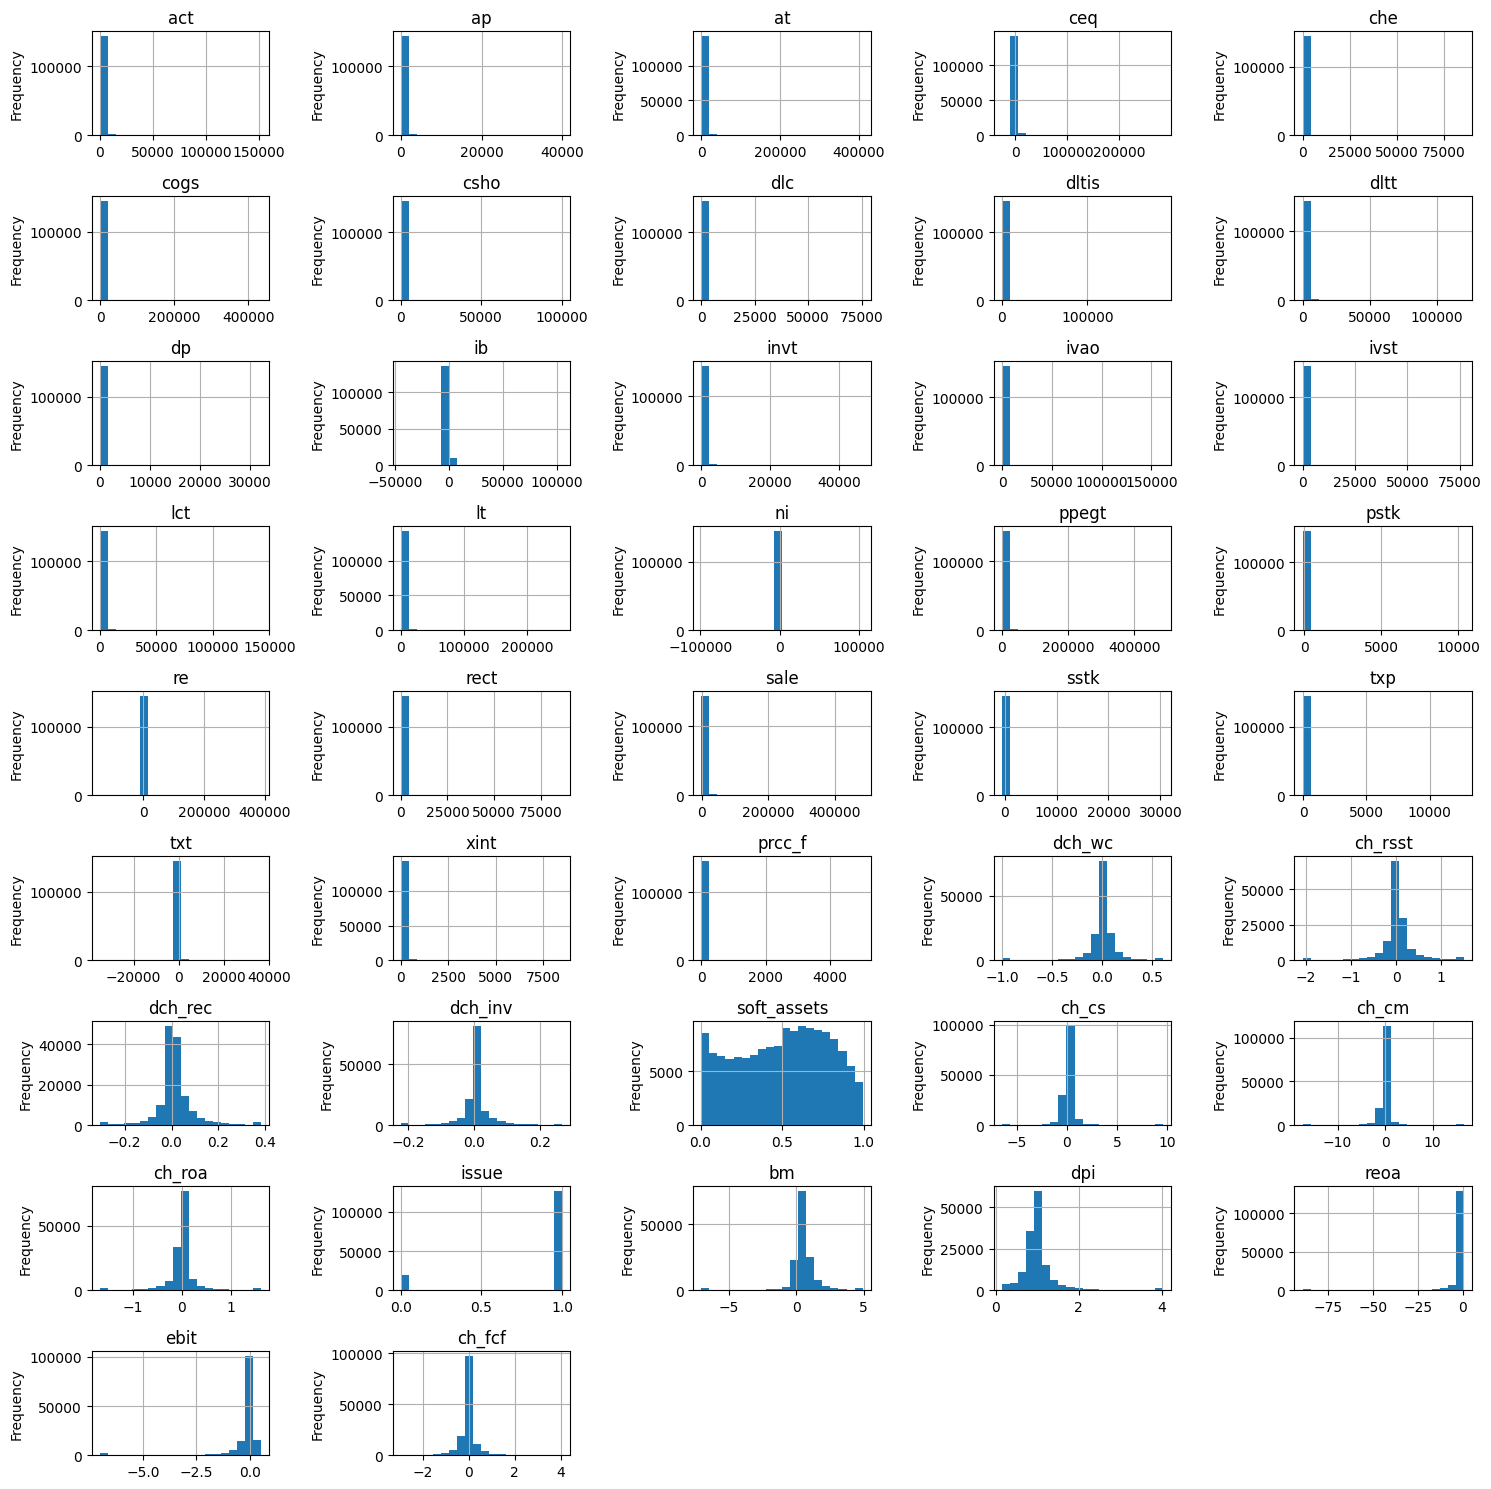

In [25]:
features_to_exclude = ['fyear', 'gvkey', 'misstate', 'ch_cs_missing', 'ch_cm_missing']

# Get all column names
all_cols = fraud_data.columns.tolist()

# Identify the columns to plot by excluding the ones in features_to_exclude
features_to_plot = [col for col in all_cols if col not in features_to_exclude]

# Determine the number of subplots needed
n_features = len(features_to_plot)
rows = (n_features + 4) // 5  
cols = min(n_features, 5)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15)) #5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot histograms for each feature
for i, feature in enumerate(features_to_plot):
    fraud_data[feature].hist(ax=axes[i], bins=20)  # You can adjust the number of bins
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
if n_features < rows * cols:
    for j in range(n_features, rows * cols):
        fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
<b>Here is what the distributions tell us.</b><br>

<table border="1" cellpadding="5" cellspacing="0">
  <thead>
    <tr>
      <th>Features</th>
      <th>Mean</th>
      <th>Scaling Strategy</th>
      <th>Notes</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>act, ap, at, ceq, che, cogs, csho, dlc, dltis, dltt, dp, ib, invt, ivao, ivst, lct, lt, ni, ppegt, pstk, re, rect, sale, sstk, txp, txt, xint, prcc_f</td>
      <td>737.85, 181.99, 2374.04, 887.13, 218.66, 1302.28, 97.00, 127.23, 201.31, 538.38, 113.28, 99.12, 167.70, 94.51, 66.78, 566.12, 1434.34, 99.67, 1703.21, 9.35, 435.90, 268.63, 1895.84, 27.66, 23.72, 55.25, 40.16</td>
      <td>RobustScaler</td>
      <td>Strong right skew, wide range, outliers</td>
    </tr>
    <tr>
      <td>dch_wc, ch_rsst, dch_rec, dch_inv, ch_roa, dpi, ch_fcf</td>
      <td>0.0151, -0.0051, 0.0189, 0.0135, -0.0107, 1.0438, -0.2376</td>
      <td>StandardScaler</td>
      <td>Centered near 0, moderate spread</td>
    </tr>
    <tr>
      <td>bm, reoa, ebit</td>
      <td>0.4661, -3.1783, -0.2376</td>
      <td>RobustScaler or Winsorize</td>
      <td>Skewed or extreme low-end outliers</td>
    </tr>
    <tr>
      <td>soft_assets</td>
      <td>0.4999</td>
      <td>Leave as-is</td>
      <td>Already scaled [0,1]</td>
    </tr>
    <tr>
      <td>issue</td>
      <td>0.8635</td>
      <td>Leave as-is</td>
      <td>Binary (0/1)</td>
    </tr>
    <tr>
      <td>ch_cs_missing, ch_cm_missing</td>
      <td>0.1090, 0.1171</td>
      <td>Leave as-is</td>
      <td>Binary flags from missing indicators</td>
    </tr>
  </tbody>
</table>

<br><br>Outliers in raw accounting features reflect real economic scenarios. The companies' market cap has a wide range. <br>
Therefore, the outliers are not noise or errors. 
</div>



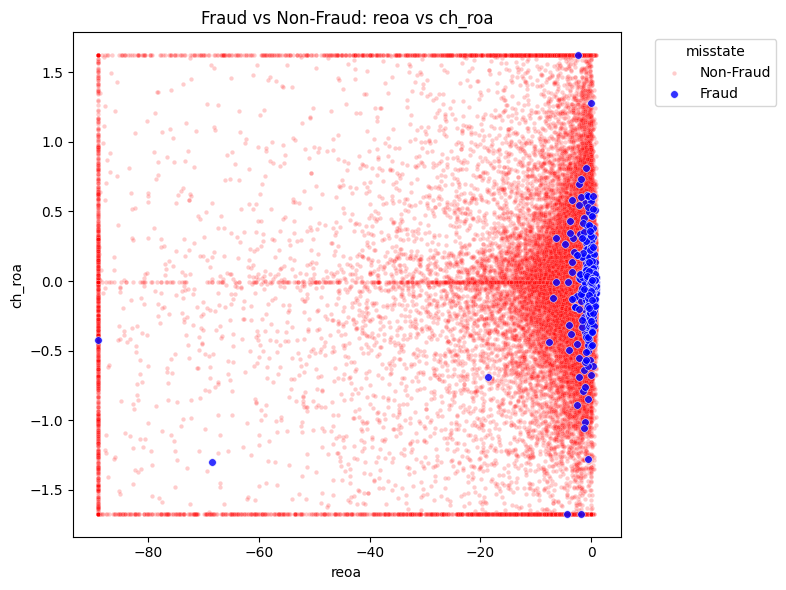

In [26]:
plot_fraud_scatter(fraud_data,'reoa','ch_roa')

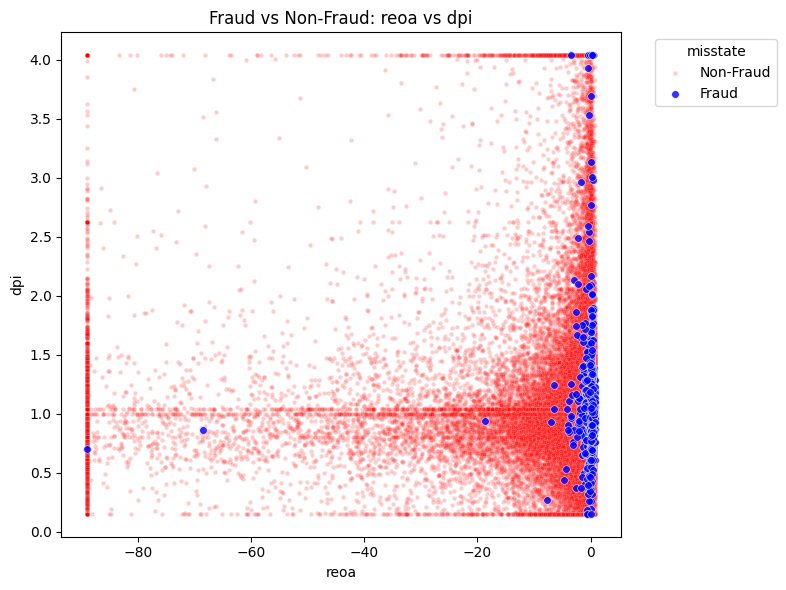

In [27]:
plot_fraud_scatter(fraud_data,'reoa','dpi')


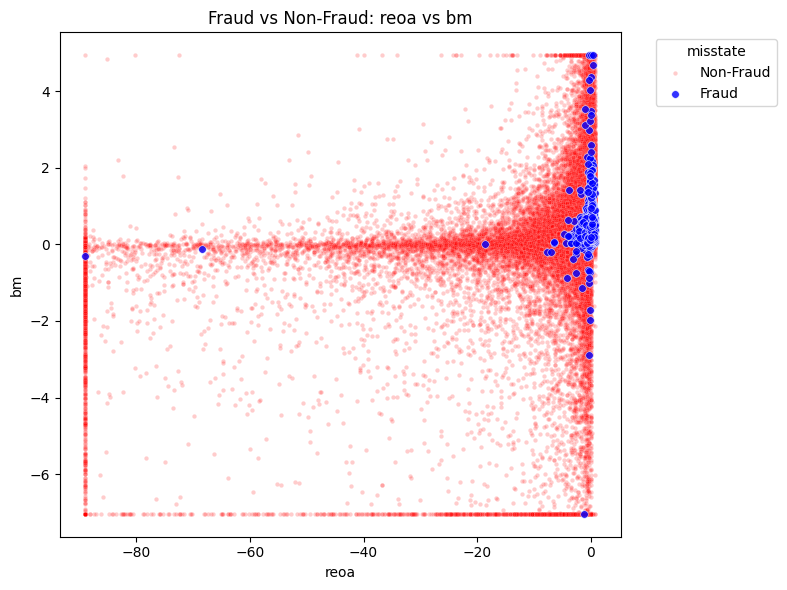

In [28]:
plot_fraud_scatter(fraud_data,'reoa','bm')

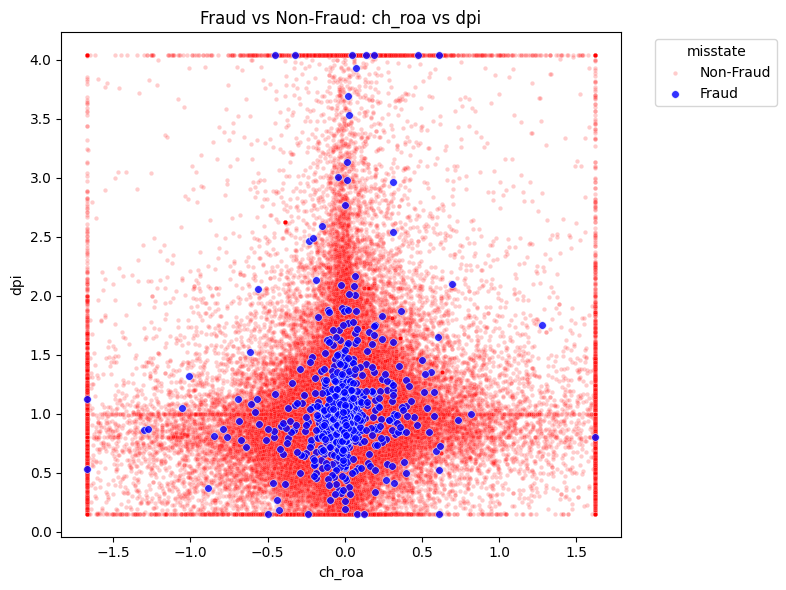

In [29]:
plot_fraud_scatter(fraud_data,'ch_roa','dpi')

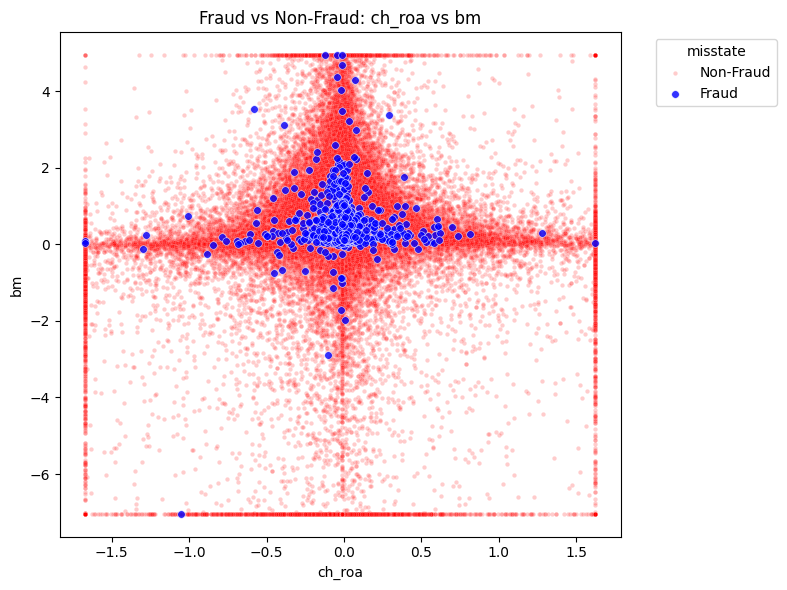

In [30]:
plot_fraud_scatter(fraud_data,'ch_roa','bm')

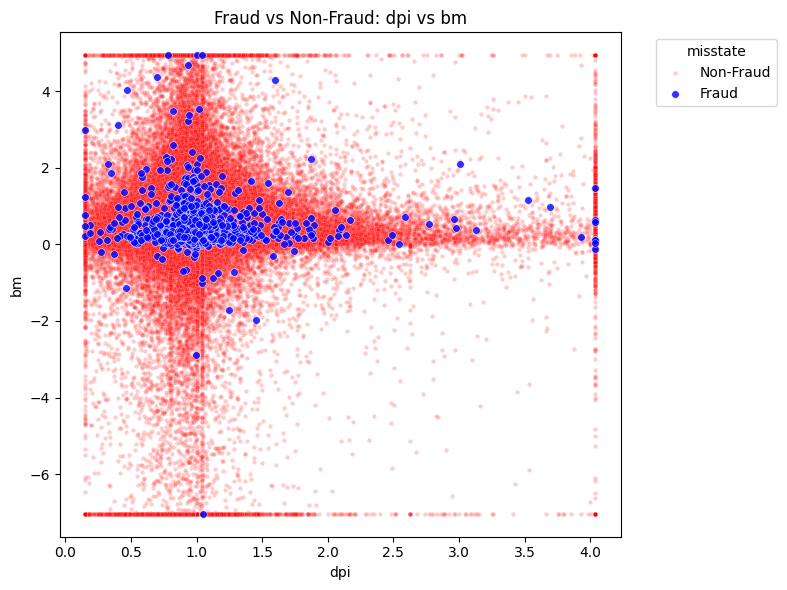

In [31]:
plot_fraud_scatter(fraud_data,'dpi','bm')

<div class="alert alert-block alert-info">In all the scatter plots, fraud cases are clustered and concentrated in a single region<br>
We will use these two feature pairs moving forward, with the caveat that we might come back and revisit the other 4 pairs.<br><br>
<li>ch_roa vs dpi</li>
<li>reoa vs ch_roa</li><br>
We will pairplot these pairs</div>


In [32]:
pair_features = ['ch_roa', 'dpi', 'reoa']
#plot_fraud_pairplot(fraud_data, pair_features)

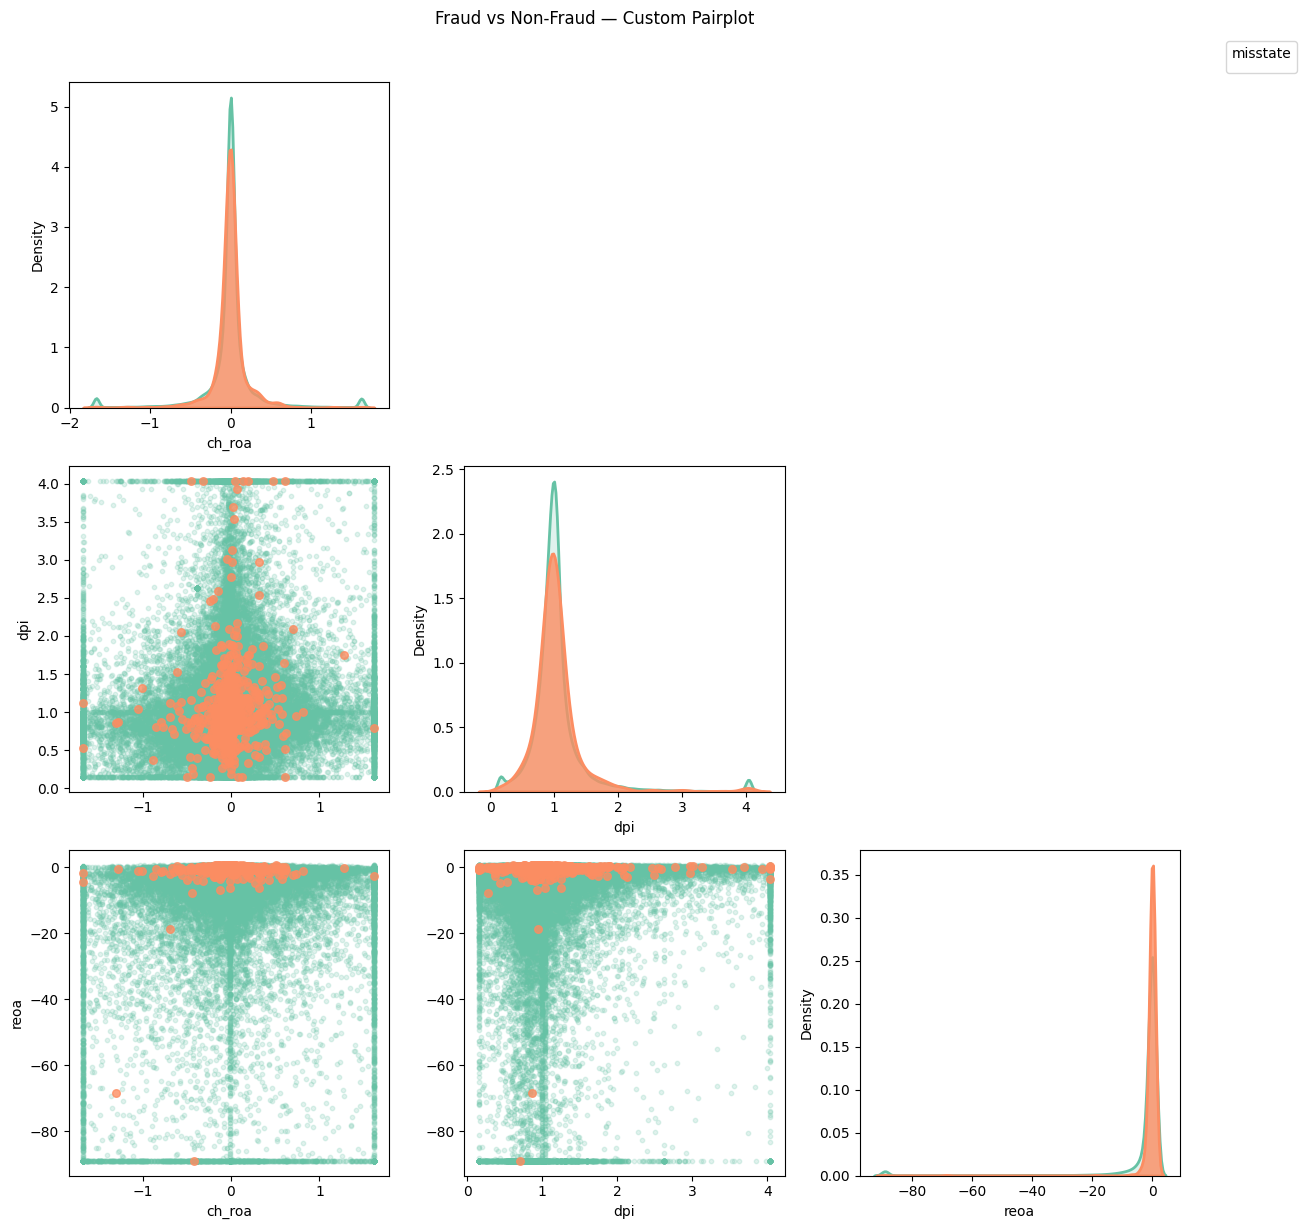

In [33]:
custom_fraud_pairplot(fraud_data, pair_features)


<div class="alert alert-block alert-info"><h2>Save Data</h2></div>


In [34]:
# Save full cleaned DataFrame

# Define base path
datapath = "../data"

# Save full cleaned DataFrame
fraud_data.to_csv(os.path.join(datapath, "fraud_data_clean.csv"), index=False)
nN_updated.to_csv(os.path.join(datapath, "fraud_model_features.csv"), index=False)


### <div class="alert alert-block alert-info"><h3>Wrangling Complete</h3>
</div>


<div class="alert alert-block alert-info">
- Raw dataset cleaned, nulls imputed using category-specific strategies (KNN, median, iterative)<br>
- Derived fraud signal features added<br>
- Outliers retained as informative for tree-based models<br>
- Saved cleaned data to `../data/fraud_data_clean.csv`
</div>


<div class="alert alert-block alert-info">

<b>Wrangling Summary</b><br>

This notebook performed structured data wrangling on a financial dataset intended for fraud detection modeling.<br>

<ul>
  <li><b>Original dataset:</b> 146,045 rows and 47 columns</li>
  <li><b>Target feature:</b> <code>misstate</code> (provided, not derived)</li>
  <li><b>Rows removed:</b> None — all company-year records retained</li>
  <li><b>Columns removed:</b> <code>p_aaer</code> — >99% missing and non-predictive (SEC document ID)</li>
  <li><b>Column types:</b> All features are numerical; no categorical encoding required</li>
  <li><b>Missing value handling:</b>
    <ul>
      <li><b>KNN Imputer:</b> Moderate-miss features (e.g., <code>dch_wc</code>, <code>ch_fcf</code>)</li>
      <li><b>Median Imputer:</b> Low-miss features (e.g., <code>bm</code>, <code>ebit</code>)</li>
      <li><b>Iterative Imputer:</b> High-miss features (e.g., <code>ch_cs</code>, <code>ch_cm</code>)</li>
      <li><b>Binary Flags Added:</b> <code>ch_cs_missing</code>, <code>ch_cm_missing</code></li>
    </ul>
  </li>
  <li><b>Duplicates:</b> None found — all firm-year combinations unique</li>
  <li><b>Outliers:</b> Retained — distributions reflect real-world financial variation</li>
  <li><b>Final shape:</b> 146,045 rows × 46 columns (fully imputed, modeling-ready)</li>
  <li><b>Next step:</b> Proceed to <code>02_eda.ipynb</code>. Conduct an in-depth exploratory data analysis (EDA) to assess variable distributions, relationships, and feature importance before model training. </li>
</li>
</ul>

</div>



In [35]:
fraud_data.shape

(146045, 47)

In [36]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

Total execution time: 166.61 seconds


<div class="alert alert-block alert-info">
 <a href= https://github.com/BTExpress1/accounting-fraud-detection/blob/045bf9a8bade822dcc043cc45f1c3f5de928e3d6/notebooks/02_eda.ipynb>Here is the EDA notebook: 02_eda.ipynb</a>
</div>
